# Identifying & Quantifying Missing Weather Data

Load in required packages:

In [347]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import xarray as xr
from datetime import datetime
import time 

Read in temperature, precip, RH & solar radiation data:

In [125]:
# these are loading the updated files generated through a more streamlined process
df_temp = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/temp_all.csv', index_col= 0)
df_rh = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/rh_all.csv', index_col= 0)
df_precip = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/precip_all.csv', index_col= 0)
df_solrad = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/backup/solrad_all.csv', index_col= 0)

# processing solar radiation data to only include growing season
df_solrad = df_solrad.reindex(df_temp.index)
print(df_temp.shape)
print(df_rh.shape)
print(df_precip.shape)
print(df_solrad.shape)

(154110, 237)
(154110, 237)
(154110, 237)
(154110, 237)


In [126]:
# saving the updated solar radiation data
df_solrad.to_csv('/home/disk/eos8/ach315/upscale/weadata/solrad_all.csv')

Putting all the weather data into xarray

In [127]:
timepoints = pd.to_datetime(df_temp.index)
sites = df_temp.columns

ds_weadata = xr.Dataset({"temperature": (["time", "loc"], df_temp),
                         "precipitation": (["time", "loc"], df_precip),
                         "relhumidity": (["time", "loc"], df_rh),
                         "solrad": (["time", "loc"], df_solrad)},
                        coords= {"time": timepoints,
                                 "loc": sites})

ds_weadata

<xarray.Dataset>
Dimensions:        (loc: 237, time: 154110)
Coordinates:
  * time           (time) datetime64[ns] 1961-04-01 1961-04-01T01:00:00 ...
  * loc            (loc) object '03103' '03812' '03813' '03820' '03822' ...
Data variables:
    temperature    (time, loc) float64 nan 8.9 17.2 15.0 18.9 14.4 nan nan ...
    precipitation  (time, loc) float64 nan nan 5.0 15.0 0.0 30.0 nan nan nan ...
    relhumidity    (time, loc) float64 nan 92.74 86.7 100.0 93.21 93.01 nan ...
    solrad         (time, loc) float64 nan 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...

In [5]:
# 190910: Depricated Code
# these are loading the old weather files that are now in backup
df_temp = pd.read_csv("/home/disk/eos8/ach315/upscale/weadata/backup/temp_all.csv", index_col= 0)
df_precip = pd.read_csv("/home/disk/eos8/ach315/upscale/weadata/backup/precip_all.csv", index_col= 0)
df_rh = pd.read_csv("/home/disk/eos8/ach315/upscale/weadata/backup/rh_all.csv", index_col= 0)
df_solrad = pd.read_csv("/home/disk/eos8/ach315/upscale/weadata/backup/solrad_all.csv", index_col= 0)

### Step 1. Figure out site-years that can be gap-filled

In [599]:
#--- Setting up variables
# variable input for loop

# weather datasets to process
datasets = list([df_temp, df_rh, df_precip, df_solrad]) # df_rh is based off df_temp, so no need to evaluate 

# final lists to store processed output
finalist = list([[], [], [], []]) # order: [0]-temp, [1]-precip, [2]-solrad

# years
years = np.arange(1961, 1991)

# growing season
growseason_start = '-04-01 00:00:00'
growseason_end = '-10-31 23:00:00'

# critical hrs of missing data
crit_hrs = 1

In [600]:
#--- Loop
# looking through the temp, precip & solrad dataset to pick out usable site-years

for i in np.arange(len(datasets)):
    dataset = datasets[i]
    siteyears_all = list()
    sites = dataset.columns
    
    for j in years:
        start_time = str(j) + growseason_start
        end_time = str(j) + growseason_end
        siteyears = list()
        
        for k in sites:
            df = dataset.loc[start_time:end_time, k] 
            df = pd.DataFrame(df)
            df['group'] = df.notnull().astype(int) # df.notnull() returns TRUE or FALSE, 
                                                   # .astype(int) turns TRUE into 1, and FALSE into 0
            df['group'] = df.group.cumsum() # calculating cumulative sum 
            df = df[df.iloc[:,0].isnull()] # selecting out individual timesteps that have missing data
            df['count'] = df.groupby('group')['group'].transform('size') # counts the number of consecutive NANs 
            df = df.drop_duplicates('group')
            
            if df[df['count'] > crit_hrs].shape[0] == 0:
                use_siteyear = str(j) + '_' + str(k)
                siteyears.append(use_siteyear) # only record site-years that have fewer consecutive NANs than the critical value set
        
        siteyears_all.extend(siteyears)
    
    finalist[i] = siteyears_all


### Step 2. Compare usable site-years for temp  & precip and find the common year-sites

In [601]:
yearsites_temp = finalist[0]
yearsites_rh = finalist[1]
yearsites_precip = finalist[2]
yearsites_solrad = finalist[3]

print('temp:', len(yearsites_temp))
print('precip:', len(yearsites_precip))
print('solrad:', len(yearsites_solrad))

yearsites = list(set(yearsites_temp) & set(yearsites_rh))
yearsites = list(set(yearsites) & set(yearsites_precip))
yearsites = list(set(yearsites) & set(yearsites_solrad))

yearsites.sort()

print('overlapping siteyears:', len(yearsites))

temp: 2838
precip: 2254
solrad: 7097
overlapping siteyears: 2125


In [561]:
#crithrs_0 = len(yearsites)
#crithrs_1 = len(yearsites)
#crithrs_2 = len(yearsites)
#crithrs_3 = len(yearsites)

### Step 3. Visualize output

<BarContainer object of 4 artists>

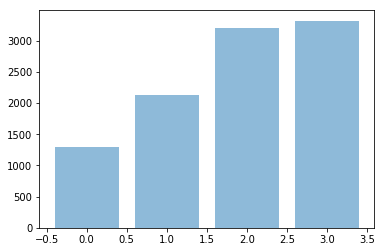

In [562]:
x = [0,1,2,3]
width =  [crithrs_0, crithrs_1, crithrs_2, crithrs_3]
plt.bar(x, width, alpha=0.5)

### Step 4. Parse out the year-sites into a dataframe that has usable year as a column & site as a column 

In [603]:
years = list()
sites = list()

for i in range(len(yearsites)):
    year = yearsites[i][0:4]
    years.append(year)
    site = yearsites[i][5:10]
    sites.append(site)

df_yearsites = pd.DataFrame({'site': sites, 'year': years}, 
                            columns=['site', 'year'])
df_yearsites = df_yearsites.sort_values(['site', 'year'])
final_sites = list(set(df_yearsites.site))

In [604]:
#df_yearsites.to_csv('../weadata/site_year_crithr1.csv')

In [299]:
numofyears = list()

for i in final_sites:
    years = len(df_yearsites[df_yearsites["site"] == i])
    numofyears.append(years)
    
df_numofyears = pd.DataFrame({"site": final_sites,
                              "years": numofyears})
df_numofyears = df_numofyears.sort_values(["site"])
df_numofyears = df_numofyears.reset_index().iloc[:, 1:3]

In [139]:
#df_numofyears.to_csv("../weadata/site_years.csv")

### Step 5. Select for subset dataset to include only valid (can be gap-filled) weather data

Read in required files:

In [ ]:
siteyear = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/site_year_crithr1.csv', dtype="str")
siteyear = siteyear.drop(siteyear.columns[0], axis=1)
print(siteyear.shape)
siteyear.head()

Read in individual weather data files and merge them into long form data frame:

In [50]:
# 190923: still thinking whether the code below in this step 5 section is necessary now

filelist = ['temp_all.csv', 'precip_all.csv', 'rh_all.csv', 'solrad_all.csv']
weavars = ['temp', 'precip', 'rh', 'solrad']
filenums = len(filelist)
dfs = [[],[],[],[]]
sites = sorted(list(set(siteyear.site)))
grow_months = [5,6,7,8,9,10]


for i in range(filenums):
    dfs[i] = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/' + filelist[i], index_col=0)
    dfs[i].index = pd.to_datetime(dfs[i].index) # converting index timepoint into datetimeindex
    dfs[i] = dfs[i][dfs[i].index.month.isin(grow_months)] # selecting only the growing season timepoints
    dfs[i] = dfs[i].filter(items=sites, axis=1) # selcting only the valid sites
    dfs[i]["date"] = dfs[i].index # creating another column that stores datetimeindex info, for melting purpose
    dfs[i] = pd.melt(dfs[i], id_vars="date", var_name="sites", value_name=weavars[i])

df = pd.merge(dfs[0], dfs[1])
df = pd.merge(df, dfs[2])
df = pd.merge(df, dfs[3])    

df.index = pd.to_datetime(df.date)
df = df.iloc[:, 1:]
df.head()

,sites,temp,precip,rh,solrad
date,,,,,
1961-05-01 00:00:00,03103,NaN,NaN,NaN,NaN
1961-05-01 01:00:00,03103,NaN,NaN,NaN,NaN
1961-05-01 02:00:00,03103,NaN,NaN,NaN,NaN
1961-05-01 03:00:00,03103,NaN,NaN,NaN,NaN
1961-05-01 04:00:00,03103,NaN,NaN,NaN,NaN


Selecting for valid site & years:

In [ ]:
valid_siteyears = siteyear.shape[0]
frames = []

for i in range(valid_siteyears):
    dfi = df[df.index.year == int(siteyear.year[i])]
    dfi = dfi[dfi.sites == siteyear.site[i]]
    frames.append(dfi)
#    print(len(frames)) # since this code takes time to run, 
                       # this helps to see where in the process it is

df_valid = pd.concat(frames)

Saving valid weather data frame into .csv:

In [52]:
print(df_valid.head())
print(df_valid.tail())
df_valid.to_csv("/home/disk/eos8/ach315/upscale/weadata/weadata.csv")

                     sites  temp  precip        rh  solrad
date                                                      
1964-05-01 00:00:00  03103   9.4     0.0  0.605071     0.0
1964-05-01 01:00:00  03103   5.6    15.0  0.850413     0.0
1964-05-01 02:00:00  03103   4.4     0.0  0.925122     0.0
1964-05-01 03:00:00  03103   3.3     0.0  0.924547     0.0
1964-05-01 04:00:00  03103   2.8     0.0  0.924283     0.0
                     sites  temp  precip        rh  solrad
date                                                      
1990-10-31 19:00:00  94910  21.1     0.0  0.543996     0.0
1990-10-31 20:00:00  94910  22.8     0.0  0.470004     0.0
1990-10-31 21:00:00  94910  23.3     0.0  0.440605     0.0
1990-10-31 22:00:00  94910  22.8     0.0  0.454449     0.0
1990-10-31 23:00:00  94910  19.4     0.0  0.562429     0.0


### Step 6: Compile usable site-years data into individual weather data files

Code is only for 'control' maizeim weather input at the moment

In [605]:
siteyear = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/site_year_crithr2.csv', dtype="str")
siteyear = siteyear.drop(siteyear.columns[0], axis=1)

for i in np.arange(siteyear.shape[0]): 
    # selecting site-year combinations
    site = siteyear.iloc[i,0]
    year = siteyear.iloc[i,1]
    
    # constructing dataframe that will hold all weather data
    col = ['jday','date','hour','solrad','temp','precip','rh', 'co2']
    df_wea = pd.DataFrame(columns=col)

    # setting up for time-relating entries
    season_start, season_end = '04-01-', '10-31-'
    times = pd.date_range(season_start+str(year), season_end+str(year)+' 23:00:00', freq='1H')
    dates = pd.to_datetime({'year': times.year, 'month': times.month, 'day': times.day})
    # converting dates into string format that matches maizsim input
    dates = '"' + dates.apply(str).str.split(' ').str.get(0) + '"'
    
    # setting up julian days
    jdays = np.arange(91, 305)
    jdays = np.repeat(jdays, 24)
    
    # setting up hours
    days = pd.date_range(season_start+year, season_end+year+' 23:00:00', freq='1D')
    hours = np.arange(0,24)
    hours = list(hours)*len(days)
    
    # adding time-relating info to data frame
    df_wea.jday = jdays
    df_wea.date = dates
    df_wea.hour = hours

    # setting growing season period
    datestart = year + '-04-01 00:00:00'
    datend = year + '-10-31 23:00:00'
    # selecting weather data
    df_wea.temp = list(df_temp[datestart:datend][site])
    df_wea.rh = list(np.round(df_rh[datestart:datend][site],2))
    df_wea.precip = list(df_precip[datestart:datend][site])
    df_wea.solrad = list(df_solrad[datestart:datend][site])
    df_wea.co2 = 400    

    # saving individual site-year weather file into .csv 
    df_wea.to_csv('/home/disk/eos8/ach315/upscale/weadata/data/control_2hr/' + site + '_' + year + '.csv')


### Looking into gap-filling data

In [615]:
# outputs with critical hour = 1
fnames = glob.glob('/home/disk/eos8/ach315/upscale/weadata/data/control_1hr/*')

for name in fnames: 
    test = pd.read_csv(name)
    test = test.drop(test.columns[0], axis=1)
    if test.isna().sum().sum() > 100:
        print(name.split('/')[-1], test.isna().sum().sum())

03856_1981.csv 215
13967_1981.csv 128
14735_1976.csv 327
14740_1989.csv 108
14768_1989.csv 120
14771_1974.csv 120
14771_1975.csv 111
14777_1989.csv 137
14820_1989.csv 103
14898_1975.csv 146
23042_1979.csv 196
24033_1979.csv 239
41415_1985.csv 194
93721_1974.csv 135
93730_1974.csv 126


In [617]:
test = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/data/control_1hr/03856_1981.csv')
test = test.drop(test.columns[0], axis=1)

In [618]:
test.head()

,jday,date,hour,solrad,temp,precip,rh,co2
0,91,"""1981-04-01""",0,0.0,22.2,0.0,42.03,400
1,91,"""1981-04-01""",1,0.0,21.7,0.0,40.22,400
2,91,"""1981-04-01""",2,0.0,20.0,0.0,49.92,400
3,91,"""1981-04-01""",3,0.0,21.7,0.0,56.38,400
4,91,"""1981-04-01""",4,0.0,21.7,0.0,70.02,400


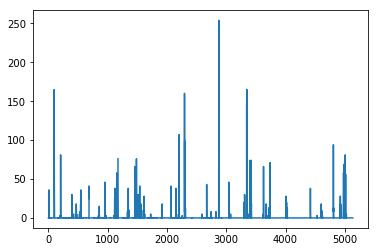

In [619]:
plt.plot(test.precip)